In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
# pip install tensorflow==2.4.1

In [104]:
import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sys, time, os, warnings
import re
import random
import json
import pickle
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

from collections import Counter 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.python.keras.backend import set_session
from glob import glob
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array


In [52]:

## The location of the Flickr8K dataset (Extracted)
dir_Flickr_jpg = "/content/gdrive/MyDrive/CV Project/data/Images/"
## The location of the caption txt file
dir_Flickr_text = "/content/gdrive/MyDrive/CV Project/data/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 16179


In [53]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()
# N = 100
# with open("/content/gdrive/MyDrive/CV Project/data/captions.txt", "r") as file:  # the a opens it in append mode
#     for i in range(N):
#         line = next(file).strip()
#         print(line)

datatxt = []
for line in text.split('\n'):
    col = line.split(',')
    if len(col) == 1:
        continue
    w = col[0].split(",")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

data.head(10)

The number of unique file names : 8092
The distribution of the number of captions for each image:


,filename,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
6,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting
7,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...
8,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...
9,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...


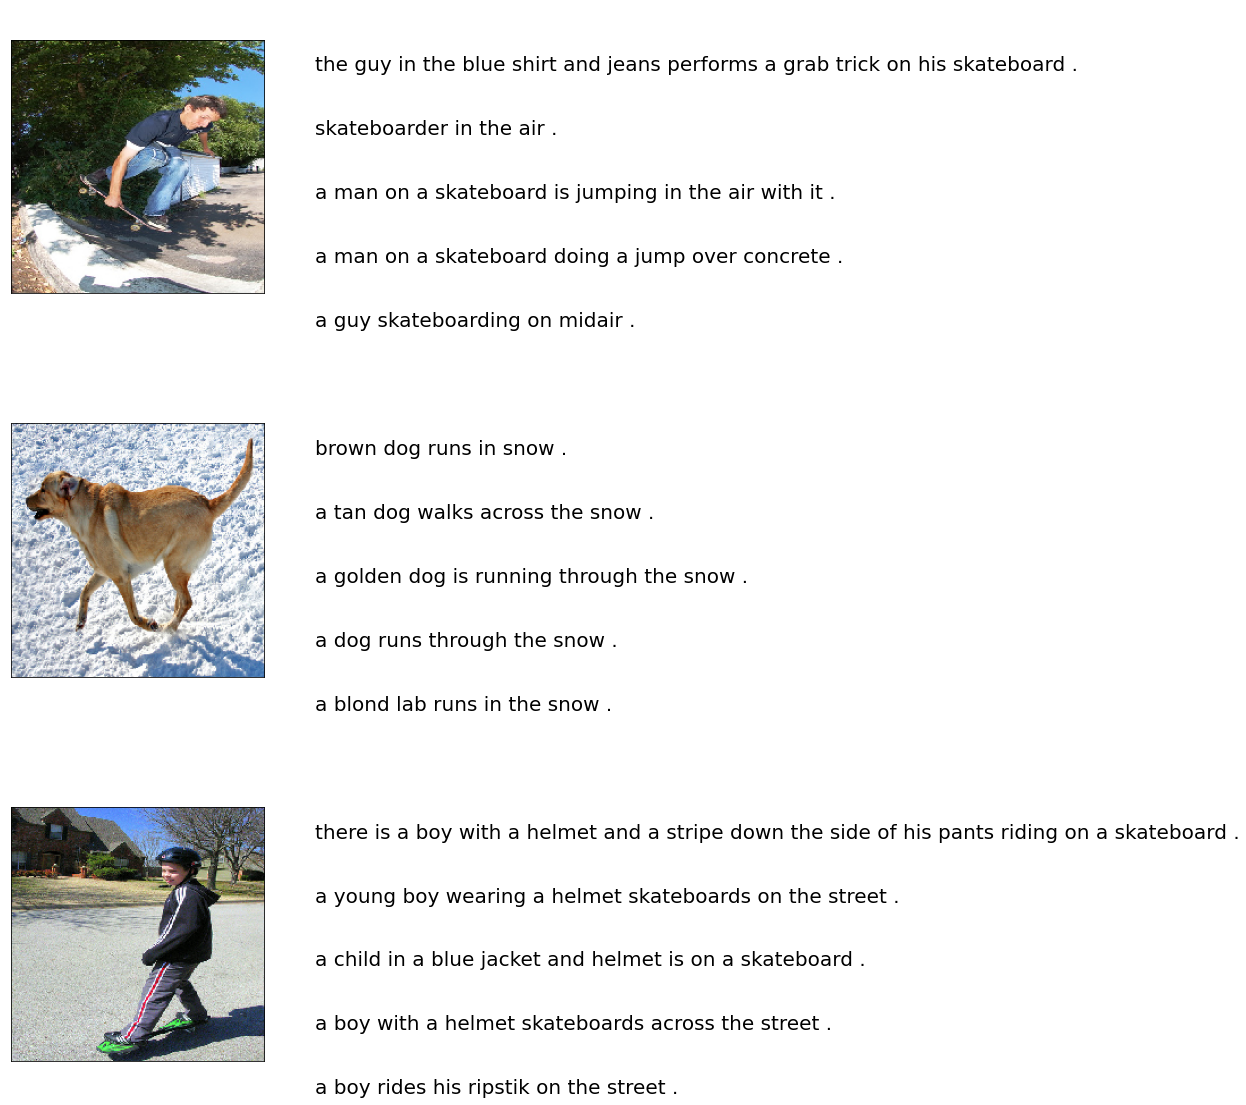

In [54]:


npic = 3
npix = 224
target_size = (npix,npix,3)
staa = random.randint(1,5000)
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[staa:staa+3]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [55]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 8872


In [56]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
# ct.keys()

Vocabulary Size: 8872


In [57]:
img = data["filename"].tolist()
caption = data["caption"].tolist()
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

len(img) : 40456
len(caption) : 40456
Total Unique imgs : 8092
total unique captions : 39891


In [58]:
PATH = "/content/gdrive/MyDrive/CV Project/data/Images/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:5]

['<start> caption <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>']

In [59]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/gdrive/MyDrive/CV Project/data/Images/image',
 '/content/gdrive/MyDrive/CV Project/data/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/CV Project/data/Images/1001773457_577c3a7d70.jpg']

In [60]:
train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

len(img_name_vector)

priviously we had 40456 captions, and Now we have 10000.


10000

In [61]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [62]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [63]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"BatchDataset shapes--> {image_dataset}")

BatchDataset shapes--> <BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


In [64]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


 97%|█████████▋| 93/96 [1:40:44<02:58, 59.54s/it]

OSError: ignored

In [65]:
bf.numpy().shape


(49, 512)

In [66]:
print(batch_features.numpy().shape)

(64, 49, 512)


In [67]:
top_k = 50000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Creating tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Padding each vector to the max caption length
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)

(10000, 32)


In [68]:
max_length = calc_max_length(train_seqs)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector,test_size=0.2,random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8000, 8000, 2000, 2000)

In [69]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [70]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [71]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [72]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [73]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [74]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [75]:
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# encoder.compile()
# encoder.summary()

In [76]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  # train_loss(loss)
  # train_accuracy(labels, predictions)

  return loss, total_loss

In [77]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 3 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 5 Batch 0 Loss 3.0723
Epoch 5 Batch 100 Loss 1.7634
Epoch 5 Batch 200 Loss 1.6301
Epoch 5 Loss 1.775283
Time taken for 1 epoch 637.4416320323944 sec

Epoch 6 Batch 0 Loss 1.4883
Epoch 6 Batch 100 Loss 1.3275
Epoch 6 Batch 200 Loss 1.2243
Epoch 6 Loss 1.394884
Time taken for 1 epoch 539.1726443767548 sec

Epoch 7 Batch 0 Loss 1.4761
Epoch 7 Batch 100 Loss 1.3488
Epoch 7 Batch 200 Loss 1.2219
Epoch 7 Loss 1.210844
Time taken for 1 epoch 506.23106050491333 sec

Epoch 8 Batch 0 Loss 1.2041
Epoch 8 Batch 100 Loss 1.2385
Epoch 8 Batch 200 Loss 1.0340
Epoch 8 Loss 1.096742
Time taken for 1 epoch 502.5837621688843 sec

Epoch 9 Batch 0 Loss 1.1421
Epoch 9 Batch 100 Loss 0.8806
Epoch 9 Batch 200 Loss 0.9867
Epoch 9 Loss 0.998056
Time taken for 1 epoch 505.1937732696533 sec

Epoch 10 Batch 0 Loss 0.9056
Epoch 10 Batch 100 Loss 0.7524
Epoch 10 Batch 200 Loss 1.0027
Epoch 10 Loss 0.905060
Time taken for 1 epoch 504.4862685203552 sec



In [78]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [79]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

BLEU score: 22.360679774997898
METEOR score:0.605
Real Caption: a brown dog is running in a yard
Prediction Caption: a brown dog is running through the grass


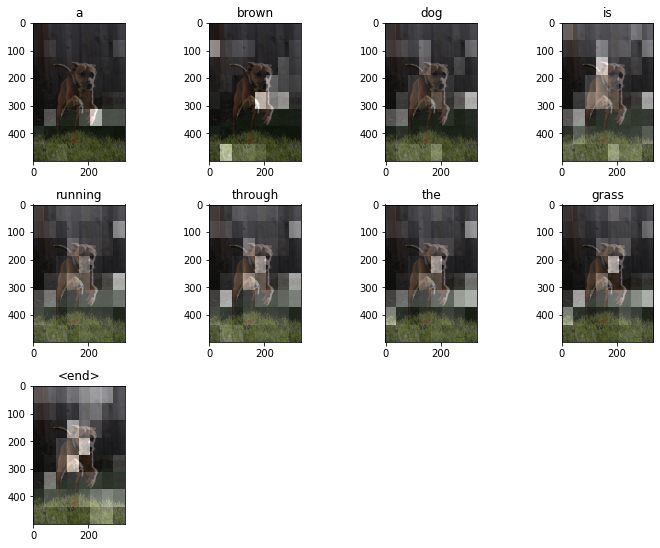

time took to Predict: 2 sec


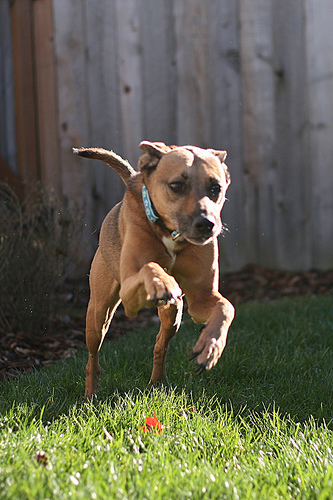

In [109]:


rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in result:
    if i=="<unk>":
        result.remove(i)
     
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")
print (f"METEOR score: {meteor_score([result_final], real_caption)}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

BLEU score: 32.444284226152504
METEOR score: 0.6642857142857144
Real Caption: a woman with a bag around her standing in the street
Prediction Caption: a woman in a street


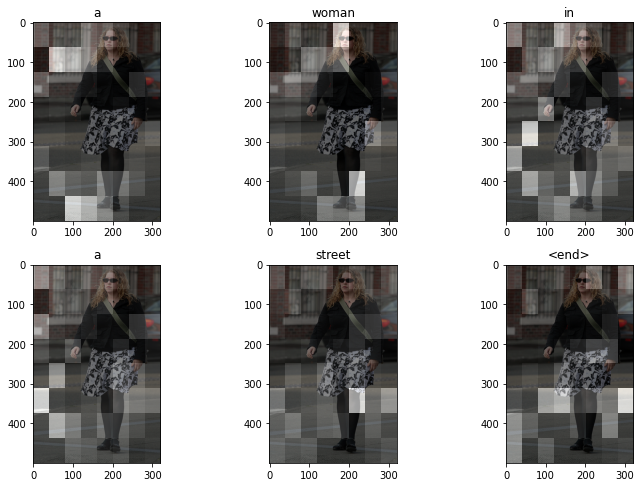

time took to Predict: 2 sec


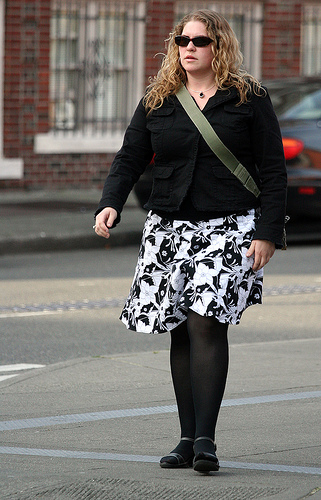

In [114]:


rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]


for i in result:
    if i=="<unk>":
        result.remove(i)

     
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")
print (f"METEOR score: {meteor_score([result_final], real_caption)}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])